# Module 5 - Spooky Authorship Identification
#### Group 13
- Aidan Lonergan
- Daniel Lillard
- Radhika Garg
- Claudine Uwiragiye

<hr>

### Objective
1) Accurately identify the author of the sentences in the test set
2) Perform all work with Apache Spark

<hr>

### Stage 0 - Import Data
1) Create a code notebook called: code_6_of_10_data_mine_group13.ipynb
2) Load the dataset into Spark data objects and explore structure, size, and distribution of information

In [1]:
# Stage 0 Solution
from pyspark.sql import SparkSession

# Start spark session and load training data set
spark = SparkSession.builder.appName("Module_5_Project").getOrCreate()
df_train = spark.read.csv('./train.csv', header=True, inferSchema=True, quote='"', escape='"')

##### Summary

In [2]:
# Print size and descriptive statistics
print("==== DataSet Shape ====")
print(f"{len(df_train.columns)} columns\n{df_train.count()} rows\n")

print("==== DataSet Descriptive Statistics ====")
print(df_train.describe().show())

print("\n==== DataSet Unique Authors ====")
print(df_train.select('author').distinct().show())

==== DataSet Shape ====
3 columns
19579 rows

==== DataSet Descriptive Statistics ====
+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   NULL|                NULL|  NULL|
| stddev|   NULL|                NULL|  NULL|
|    min|id00001|" Odenheimer, res...|   EAP|
|    max|id27971|you could not hop...|   MWS|
+-------+-------+--------------------+------+

None

==== DataSet Unique Authors ====
+------+
|author|
+------+
|   MWS|
|   HPL|
|   EAP|
+------+

None


<hr>

### Stage 1 - Data Preparation (Exploratory data analysis and text mining pre-processing)
1) Perform exploratory data analysis and create visualizations and tables as needed
2) Text Preprocessing: perform tasks like tokenization and stopwords removal to clean text data
    - Tokenize - split the text into individual words aka tokens.
    - Remove stop.words - frequently used pronouns and personal references.
        - Top ten include: I, you, he, she, it, we, they, me, him, her
    - Lemmatization - convert words to their root (optional).
        - Lemmatization is a text normalization technique that reduces words to their base or dictionary form (lemma). Use to reduce inflected or derived words to their root form for better analysis and modeling outcomes

In [ ]:
# Stage 1 Analysis (Due Friday 7/18)
# Radhika


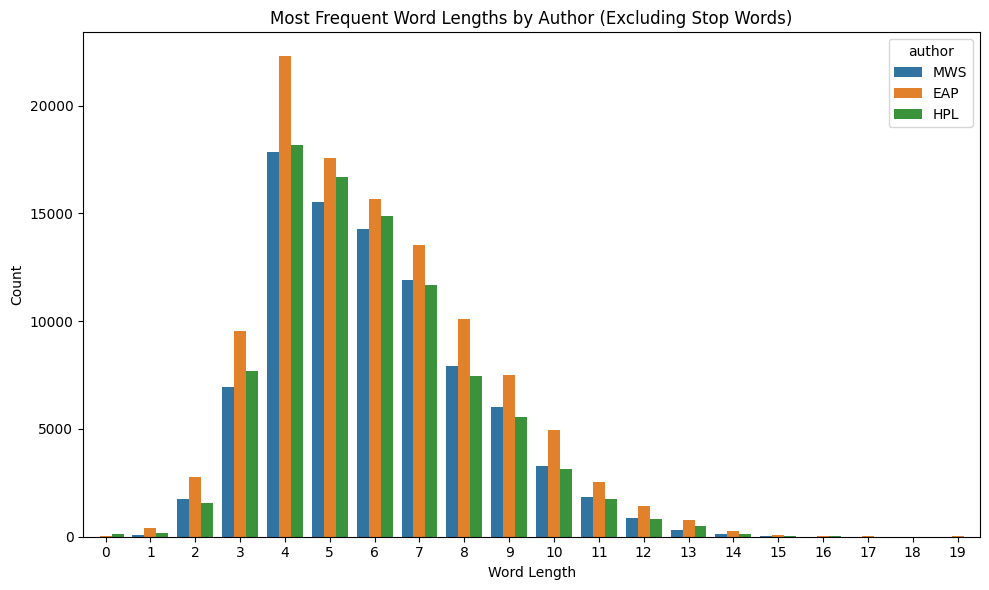

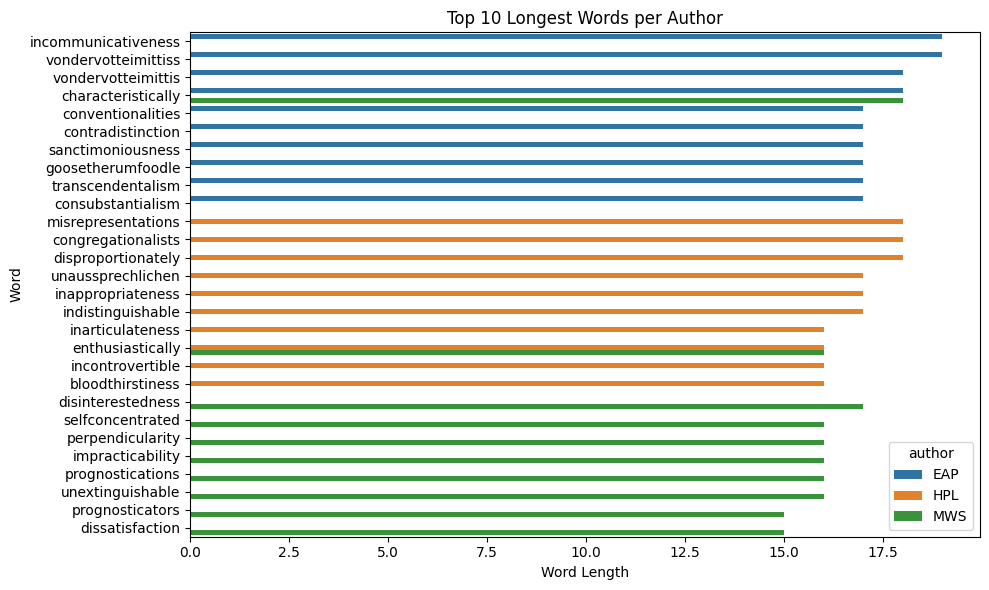

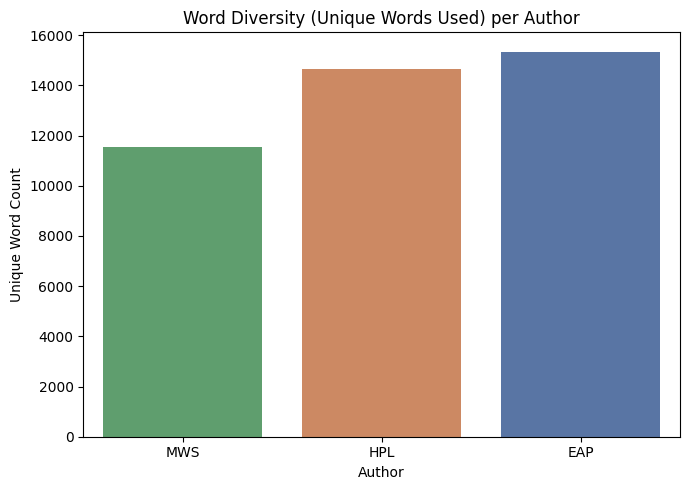

In [ ]:
# Stage 1 Visualizations (Due Friday 7/18)
# Claudine

from pyspark.sql.functions import col, split, explode, length, lower, regexp_replace, count, row_number
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

# Clean and lowercase text, remove punctuation
df_cleaned = df_train.withColumn("clean_text", lower(regexp_replace(col("text"), r"[^\w\s]", "")))

# Tokenize into words
df_words = df_cleaned.withColumn("word", explode(split(col("clean_text"), r"\s+")))

# common stop words
stop_words = [
    'the', 'and', 'is', 'in', 'to', 'of', 'a', 'that', 'it', 'on', 'for', 'as', 'with',
    'was', 'at', 'by', 'an', 'be', 'this', 'from', 'or', 'are', 'which', 'but', 'not',
    'have', 'has', 'had', 'they', 'you', 'he', 'she', 'we', 'their', 'its', 'his',
    'her', 'been', 'my', 'i', 'would', 'i', 'you', 'your', 'me', 'myself', 'us', 
    'our', 'ourselves', 'they', 'them', 'their','when', 'where', 'why', 'how', 
    'what', 'who', 'whom', 'which', 'whose', 'there', 'here', 'then', 'now', 'so', 'such'
]

# Remove stop words
df_filtered = df_words.filter(~col("word").isin(stop_words))

# ---------- CHART 1: Most Frequent Word Lengths ----------
df_word_lengths = df_filtered.withColumn("length", length(col("word")))
df_grouped = df_word_lengths.groupBy("author", "length").count()
pdf = df_grouped.toPandas()

# Plot chart 1
plt.figure(figsize=(10, 6))
sns.barplot(data=pdf, x="length", y="count", hue="author")
plt.title("Most Frequent Word Lengths by Author (Excluding Stop Words)")
plt.xlabel("Word Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------- CHART 2: Top 10 Longest Words per Author ----------
df_longest = df_word_lengths.groupBy("author", "word") \
    .agg(count("*").alias("count")) \
    .withColumn("length", length(col("word")))

windowSpec = Window.partitionBy("author").orderBy(col("length").desc())
df_top_longest = df_longest.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") <= 10)

pdf_longest = df_top_longest.select("author", "word", "length").toPandas()

# Plot chart 2
plt.figure(figsize=(10, 6))
sns.barplot(data=pdf_longest, x="length", y="word", hue="author")
plt.title("Top 10 Longest Words per Author")
plt.xlabel("Word Length")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# ---------- CHART 3: count unique words by author ----------
df_unique_words = df_filtered.select("author", "word").distinct()
df_word_diversity = df_unique_words.groupBy("author").count().withColumnRenamed("count", "unique_word_count")

# Convert to pandas
pdf_diversity = df_word_diversity.toPandas()

# Define custom color palette 
palette = {"EAP": "#4C72B0", "HPL": "#DD8452", "MWS": "#55A868"}

# Plot chart3
plt.figure(figsize=(7, 5))
sns.barplot(data=pdf_diversity, x="author", y="unique_word_count", hue="author", palette=palette, legend=False)

plt.title("Word Diversity (Unique Words Used) per Author")
plt.xlabel("Author")
plt.ylabel("Unique Word Count")
plt.tight_layout()
plt.show()


C:\Users\Claud\AppData\Local\Temp\ipykernel_39648\2983349161.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf_diversity, x="author", y="unique_word_count", palette=palette)


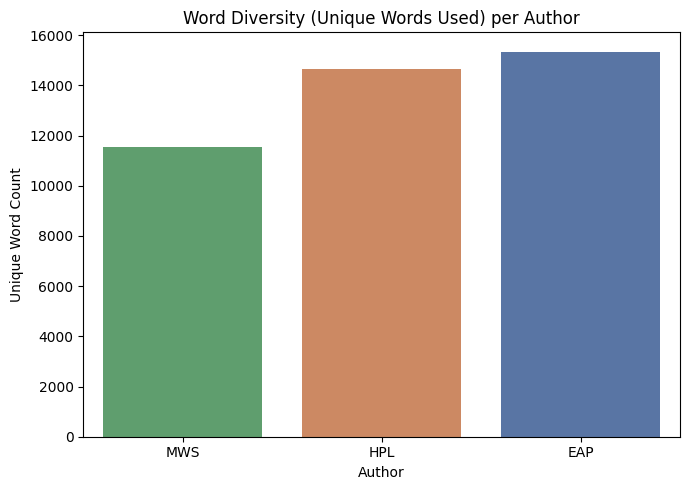

<hr>

### Stage 2 - Feature Extraction
1) Perform TFIDF to quantify word importance <href><https://en.wikipedia.org/wiki/Tf%E2%80%93idf></href>
2) Normalize is scaling or standardizing the numerical features to a standard range or distribution
    - In text mining, normalization vectorizes features with methods like TFIDF, a numerical measurement, to ensure a consistent scale
    - It handles variations in the magnitude of feature values impacting machine-learning algorithm performance. Normalize the features to ensure a similar scale and prevent features with larger values from dominating the analysis or modeling process

In [ ]:
# Stage 2 - TFIDF and Normalization (Due Friday 7/18)
# Daniel

In [ ]:
# Stage 2 Visualizations (ex: Random Forest Feature Importance) (Due Friday 7/18)
# Aidan

<hr>

### Stage 3 - Machine Learning
1) Perform train/test split
2) Perform algorithmic analysis to assess and predict test labels
    - Use as many algorithms as you need to get a good answer.
    - Supervised: logistic regression, random forest, support vector machines, etc.
    - Unsupervised: K-means, dimensionality reduction, PCA, etc.

In [ ]:
# Stage 3 Solution (Due by Monday 7/21)
# Each team member will do 2 algorithms of their choosing

In [ ]:
# Aidan:


In [ ]:
# Daniel: SVC, K-Means


In [ ]:
# Claudine:


In [ ]:
# Radhika:

<hr>

### Stage 4 - Evaluation and Visualization
1) Choose a metric strategy to assess algorithmic performance like accuracy, precision, recall, or F1 score
2) Visualize confusion matrix, correlations, and similar
3) Identify important features contributing to classification
4) Write a 2-3 sentence minimum of findings, learnings, and what you would do next

In [ ]:
# Stage 4 Solution (Due by Monday 7/21)
# Each team member will evaluate their models

In [ ]:
# Aidan

In [ ]:
# Daniel

In [ ]:
# Claudine

In [ ]:
# Radhika